# 転移学習

　事前に学習済みのモデルをカスタマイズすることを、**転移学習** と呼びます。

　ここでは、Google が開発した MobileNet V2 と呼ばれるモデルをベースにして、犬と猫の画像を分類するカスタムモデルを作成してみます。
 
　MoboleNet V2 は ImageNet データセットによって学習済みです。ImageNet は、140 万枚の画像と 1000 クラスで構成された大規模データセットです。


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils, preprocessing, optimizers, layers, models
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2, imagenet_utils

## カスタムデータセット
　カスタムデータとして、Google が TensorFlow の教育用に用意している犬と猫の画像をダウンロードします。

　下のコードを実行するとホームディレクトリ下の '.keras/datasets' に 'cats_and_dogs.zip' ファイルとそれを展開した 'cats_and_dogs_filtered' ディレクトリができます。

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
dir = utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)

　ダウンロードしたファイルを使って TensorFlow の Dataset を作成します。
 
　TensorFlow の Dataset クラスは、データを効率的に扱えるようにするクラスです。

　tensorflow.keras.preprocessing.image_dataset_from_directory はディレクトリやファイルから Dataset を作成します。ディレクトリ名が自動的に分類クラスの名前になります。
　

In [3]:
PATH = os.path.join(os.path.dirname(dir), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (96, 96)
# MobileNet V2 では以下から選択可
#　IMG_SIZE = (224,224), (192,192), (160,160), (128,128), (96,96)

IMG_SHAPE = IMG_SIZE + (3,)

# 学習用
train_dataset = preprocessing.image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
# 検証用
val_dataset = preprocessing.image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

# クラス名
class_names = train_dataset.class_names
print("Class:", class_names)

# 検証用を検証用(学習中のvalidation)とテスト用に分ける。
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 2)   # 前半 50 %
val_dataset = val_dataset.skip(val_batches // 2)    # 後半 50 %

# データの読み込みを高速化(オプション)。
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Class: ['cats', 'dogs']


すべて合わせても3000枚の画像しかないので、モデルを1から作るには不十分です。

## ベースとなるモデル
　まず、オリジナルのMobileNet V2で予測してみます。

　Keras では MobeleNet V2 をはじめ、以下のような学習済みモデルが、簡単に利用できます。

- Xception
- VGG16
- VGG19
- ResNet50
- InceptionV3
- InceptionResNetV2
- MobileNet
- DenseNet
- NASNet
- MobileNetV2

In [4]:
org_model = MobileNetV2(weights='imagenet', input_shape=IMG_SHAPE)

　読み込んだモデルで、データセットのいくつかの画像を予測してみます。
 
(注意) 学習済みモデルが想定している入力画像の形式は、モデルによって異なります(ピクセルデータが0〜255なのか-1.0〜1.0なのか、RGBなのかRBGなのかなど）。

　そこでモデル毎に用意されている 'process_input'関数を使って入力を前処理する必要があります。process_input自体の入力は 0〜255、RGBです。（ちなみに MobileNet V2は -1.0〜1.0、RGB データを想定しています)

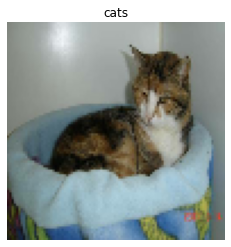

[('n02123045', 'tabby', 0.2588781),
 ('n03887697', 'paper_towel', 0.17367314),
 ('n04447861', 'toilet_seat', 0.039267987)]


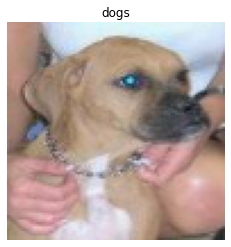

[('n02093256', 'Staffordshire_bullterrier', 0.23813662),
 ('n02108089', 'boxer', 0.20091341),
 ('n02090379', 'redbone', 0.15347926)]


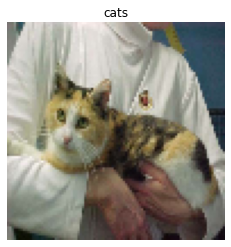

[('n02094258', 'Norwich_terrier', 0.24326347),
 ('n02342885', 'hamster', 0.09061071),
 ('n02095314', 'wire-haired_fox_terrier', 0.073339194)]


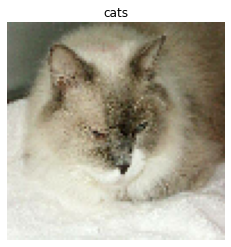

[('n02123394', 'Persian_cat', 0.41199645),
 ('n02127052', 'lynx', 0.11665548),
 ('n02123597', 'Siamese_cat', 0.08292059)]


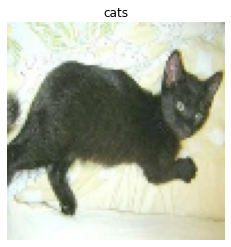

[('n02104365', 'schipperke', 0.17185815),
 ('n02124075', 'Egyptian_cat', 0.13510679),
 ('n02085620', 'Chihuahua', 0.06451666)]


In [5]:
plt.figure()

for images, labels in train_dataset.take(1):
    pred = org_model.predict(mobilenet_v2.preprocess_input(images))
    pred_dec = imagenet_utils.decode_predictions(pred, top=3)

    for i, image in enumerate(images[:5]):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.show()
        pprint(pred_dec[i])

## モデル作成

　ベースモデルから、カスタムモデルを作成します。

　一般的に、CNNは最終層に向かうほどよりデータセットに固有な特徴を学習している、とされています。したがって再学習はモデル全体でなく最終層に近い部分だけを行うのが効率的です。
 
　今回のカスタムモデルは犬か猫かの2つを分類するのが目的です。そこでベースモデルの最終層を分類数2のものに取り替え、まずはその部分のパラメータだけを学習することにします。

　モデルのインスタンスを作成する際に、'include_top=False' とすると、最終層だけを外したモデルが得られます。

　またMovileNet V2の場合、'include_top=False' を指定すると、出力は畳込みフィルタ(5x5)になります。そこで pooling='avg'（またはpooling='max')を指定すると、畳込みフィルタをプーリングして1つの値にまとめてくれます。それにより直後に Dense層を追加できるようになります。

In [71]:
base_model = MobileNetV2(weights='imagenet', 
                         include_top=False,
                         input_shape=IMG_SHAPE,
                         pooling='avg')

### 入力の整形

　preprocess_input() をどの段階で行うかについて、データセットに対して事前に行うこともできますが、今回はモデルの中で preprocess_input() を行うことにします。

　具体的には任意の関数をLayer化する keras.layers.Lambda で入力層を作ります。　

### モデル作成
　入力(preprocess_input) → ベースモデル → Dense層(最終層)のモデルを作成します。また過学習の予防として、ベースモデルの出力は Dropout 層で調整します。

In [73]:
new_model = models.Sequential()
new_model.add(layers.Lambda(mobilenet_v2.preprocess_input, input_shape=IMG_SHAPE))
new_model.add(base_model)
new_model.add(layers.Dropout(0.5))
new_model.add(layers.Dense(1, activation="sigmoid"))

### 学習済みパラメータのフリーズ
　すでに学習済みであるベースモデルのパラメータが、再学習で変更されないようにします。

In [74]:
base_model.trainable = False

　summary()でベースモデルのパラメータが'Not-trainable'であることが確認できます。

In [75]:
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 1280)             2257984   
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## コンパイル

In [76]:
learning_rate = 0.0001
new_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 学習

In [77]:
history = new_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)   

Epoch 1/10
63/63 [==============================] - 18s 241ms/step - loss: 0.6695 - accuracy: 0.6460 - val_loss: 0.4846 - val_accuracy: 0.7766
Epoch 2/10
63/63 [==============================] - 11s 174ms/step - loss: 0.5141 - accuracy: 0.7550 - val_loss: 0.3970 - val_accuracy: 0.8279
Epoch 3/10
63/63 [==============================] - 14s 215ms/step - loss: 0.4341 - accuracy: 0.8145 - val_loss: 0.3487 - val_accuracy: 0.8709
Epoch 4/10
63/63 [==============================] - 12s 193ms/step - loss: 0.3730 - accuracy: 0.8445 - val_loss: 0.2694 - val_accuracy: 0.9078
Epoch 5/10
63/63 [==============================] - 13s 207ms/step - loss: 0.3306 - accuracy: 0.8665 - val_loss: 0.2510 - val_accuracy: 0.9139
Epoch 6/10
63/63 [==============================] - 14s 211ms/step - loss: 0.2925 - accuracy: 0.8790 - val_loss: 0.2296 - val_accuracy: 0.9098
Epoch 7/10
63/63 [==============================] - 13s 202ms/step - loss: 0.2705 - accuracy: 0.8960 - val_loss: 0.2022 - val_accuracy: 0.9303

## 評価

In [78]:
loss, accuracy = new_model.evaluate(test_dataset)
print(loss, accuracy)

16/16 [==============================] - 3s 155ms/step - loss: 0.1541 - accuracy: 0.9531
0.15409018099308014 0.953125


## 学習の経過

<AxesSubplot:>

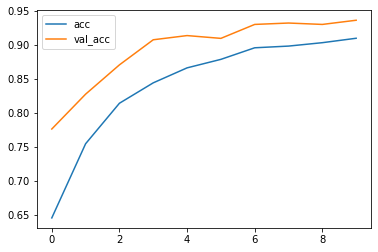

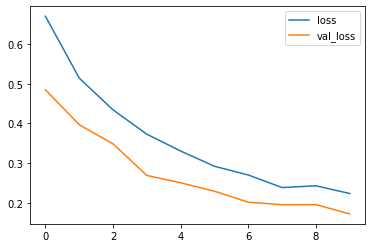

In [79]:
import pandas as pd
pd.DataFrame({'acc': history.history['accuracy'],
              'val_acc': history.history['val_accuracy']}).plot()
pd.DataFrame({'loss': history.history['loss'],
              'val_loss': history.history['val_loss']}).plot()

## ファインチューニング

　パラメータ更新をフリーズしておいたベースモデルの部分を含め、最終的にパラメータの微調整を行うことを **ファインチューニング** といいます。

　ここでも全部のパラメータを学習し直すのは非効率なので、最終段に近い方のパラメータだけフリーズを解除します。

In [80]:
# 一旦全部のフリーズを解除 
base_model.trainable = True

base_layer_num = len(base_model.layers)
print("Number of layers in the base model: ", len(base_model.layers))

# 前の方の層だけ改めてフリーズ
fine_tune_at = 130
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

print("The layers after", fine_tune_at, "layer are trainable")

Number of layers in the base model:  155
The layers after 130 layer are trainable


In [81]:
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 1280)             2257984   
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,361,281
Non-trainable params: 897,984
_________________________________________________________________


(注意) ベースモデル中には、モデルが 'trainable' でも 'trainable' にならない特殊なレイヤーが含まれています。そうしたレイヤーは原則 'trainable'にしてはいけません。そこで一部のレイヤーだけ'trainable'にするには、必ず上記のように、最初にベースモデル全部を'trainable'にして、学習不要なレイヤーだけ'trainable'をFalseにし直す、という手順で行ってください。

## コンパイル

　現状のパラメータ値を大きくは変更したくないので、学習率は小さくしておきます。

In [82]:
learning_rate /= 10
new_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 学習

In [83]:
history = new_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)   

Epoch 1/10
63/63 [==============================] - 26s 347ms/step - loss: 0.3794 - accuracy: 0.8250 - val_loss: 0.1459 - val_accuracy: 0.9447
Epoch 2/10
63/63 [==============================] - 15s 238ms/step - loss: 0.2633 - accuracy: 0.8980 - val_loss: 0.1315 - val_accuracy: 0.9529
Epoch 3/10
63/63 [==============================] - 15s 242ms/step - loss: 0.2033 - accuracy: 0.9155 - val_loss: 0.1057 - val_accuracy: 0.9611
Epoch 4/10
63/63 [==============================] - 15s 229ms/step - loss: 0.1773 - accuracy: 0.9310 - val_loss: 0.0982 - val_accuracy: 0.9652
Epoch 5/10
63/63 [==============================] - 15s 227ms/step - loss: 0.1551 - accuracy: 0.9335 - val_loss: 0.1111 - val_accuracy: 0.9488
Epoch 6/10
63/63 [==============================] - 15s 231ms/step - loss: 0.1394 - accuracy: 0.9395 - val_loss: 0.1050 - val_accuracy: 0.9549
Epoch 7/10
63/63 [==============================] - 16s 245ms/step - loss: 0.1344 - accuracy: 0.9485 - val_loss: 0.0938 - val_accuracy: 0.9631

## 評価

In [84]:
loss, accuracy = new_model.evaluate(test_dataset)
print(loss, accuracy)

16/16 [==============================] - 2s 135ms/step - loss: 0.0855 - accuracy: 0.9590
0.0854516476392746 0.958984375


## 学習の経過

<AxesSubplot:>

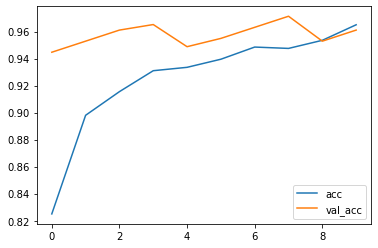

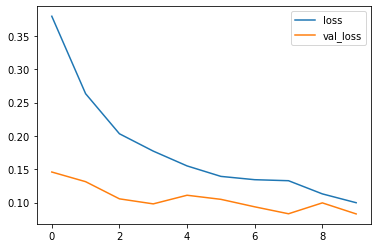

In [85]:
import pandas as pd
pd.DataFrame({'acc': history.history['accuracy'],
              'val_acc': history.history['val_accuracy']}).plot()
pd.DataFrame({'loss': history.history['loss'],
              'val_loss': history.history['val_loss']}).plot()

## 結果の確認

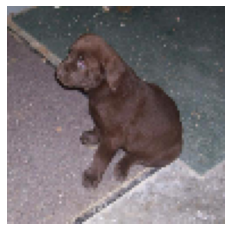

Label: dogs ,  Predicted: dogs


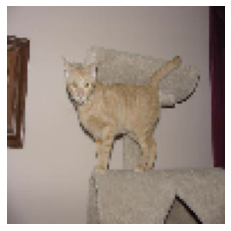

Label: cats ,  Predicted: cats


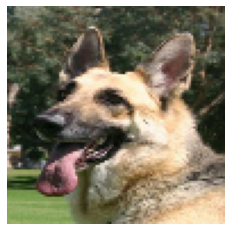

Label: dogs ,  Predicted: dogs


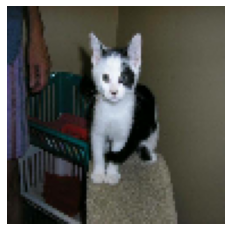

Label: cats ,  Predicted: cats


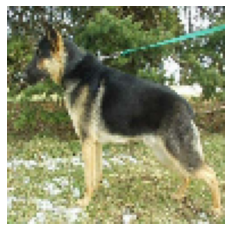

Label: dogs ,  Predicted: dogs


In [87]:
plt.figure()

for images, labels in test_dataset.take(1):
    pred = new_model.predict(images)
    for i, image in enumerate(images[:5]):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.show()
        pred_label = class_names[0] if pred[i] < 0.5 else class_names[1]
        true_label = class_names[labels[i]]
        print("Label:", true_label, ",  Predicted:", pred_label)